imports

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignorar solo ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


Carga y Preparación Inicial del Dataset

Tipos de datos:
Date             datetime64[ns]
CO(GT)                  float64
PT08.S1(CO)               Int64
NMHC(GT)                  Int64
C6H6(GT)                float64
PT08.S2(NMHC)             Int64
NOx(GT)                   Int64
PT08.S3(NOx)              Int64
NO2(GT)                   Int64
PT08.S4(NO2)              Int64
PT08.S5(O3)               Int64
T                       float64
RH                      float64
AH                      float64
Dia                       Int64
Mes                       Int64
Anio                      Int64
DiaSemana                 Int64
PeriodoDia                Int64
dtype: object

Primeros registros:
        Date  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0 2004-03-10       3         1360       150        12           1046      166   
1 2004-03-10       2         1292       112         9            955      103   
2 2004-03-10       2         1402        88         9            939      131   
3 2004-03-10     

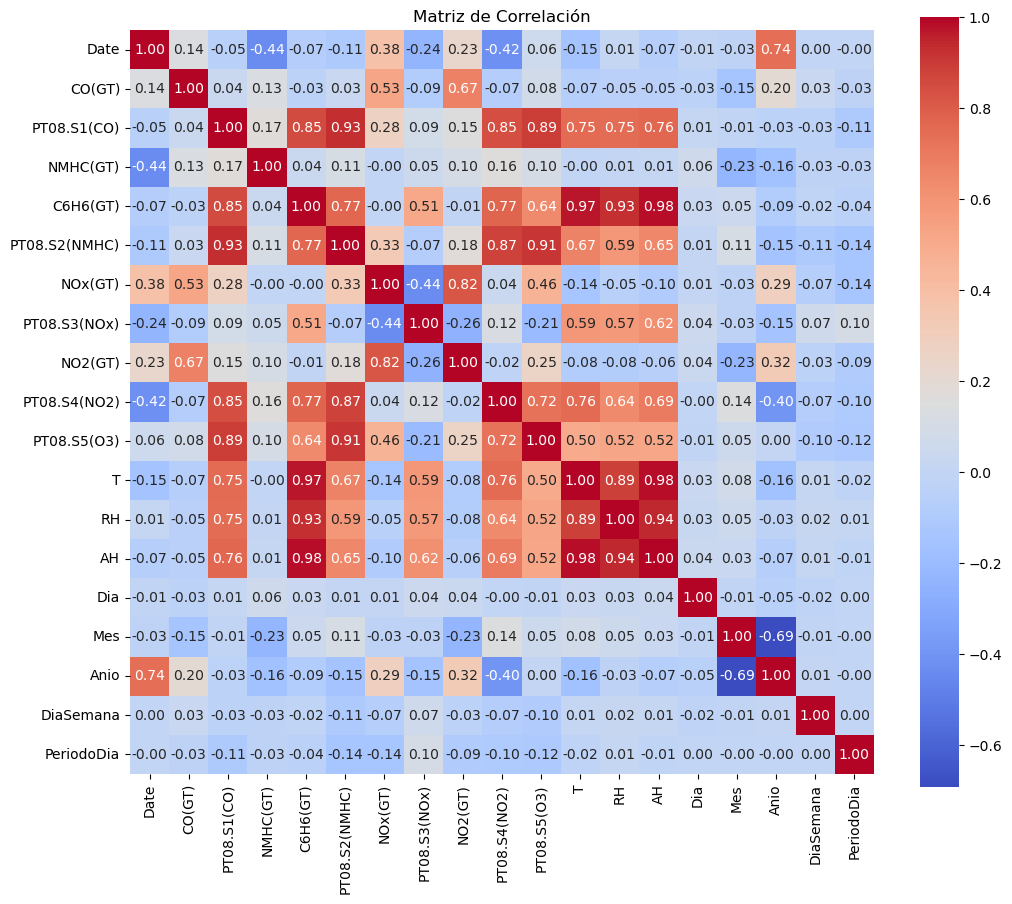

In [43]:
import pandas as pd

import pandas as pd


# Cargar los datos
df = pd.read_csv('data/AirQuality.csv', delimiter=';')

# Convertir las fechas y horas
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
# Crear las variables derivadas de 'Date'
df['Dia'] = df['Date'].dt.day
df['Mes'] = df['Date'].dt.month
df['Anio'] = df['Date'].dt.year

df['Time'] = pd.to_datetime(df['Time'], format='%H.%M.%S', errors='coerce').dt.time

# Mapear días de la semana a números
df['DiaSemana'] = df['Date'].dt.day_name()
dias_semana_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
    'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['DiaSemana'] = df['DiaSemana'].map(dias_semana_map)

# Categorizar por partes del día
def time_to_period(hour):
    if 6 <= hour < 12:
        return 0 #Día
    elif 12 <= hour < 18:
        return 1 #Tarde
    else:
        return 2 #Noche

df['PeriodoDia'] = df['Time'].apply(lambda t: time_to_period(t.hour) if pd.notnull(t) else None)

# Reemplazar comas por puntos y convertir columnas a float
columns_to_convert = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in columns_to_convert:
    df[col] = df[col].str.replace(',', '.', regex=False).astype(float)

# Convertir todas las columnas numéricas a enteros si no tienen decimales
for col in df.select_dtypes(include=['float', 'int']).columns:
    if df[col].dropna().mod(1).eq(0).all():  # Verifica si todos los valores son enteros
        df[col] = df[col].astype('Int64')  # Convierte a entero compatible con NaN

# Configuración para que no muestre decimales en pandas
pd.set_option('display.float_format', '{:.0f}'.format)


# Eliminar columnas innecesarias
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16', 'Time'], errors='ignore')
# Eliminar filas donde todos los valores, incluyendo el índice, sean NaN
df_cleaned = df.dropna()

# Mostrar información y primeros registros
print("Tipos de datos:")
print(df_cleaned.dtypes)
print("\nPrimeros registros:")
print(df_cleaned.head())

# Matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(df_cleaned.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación")
plt.show()

Limpieza de Datos

In [44]:

df_cleaned.info()
df_cleaned.head(20)

<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   CO(GT)         9357 non-null   float64       
 2   PT08.S1(CO)    9357 non-null   Int64         
 3   NMHC(GT)       9357 non-null   Int64         
 4   C6H6(GT)       9357 non-null   float64       
 5   PT08.S2(NMHC)  9357 non-null   Int64         
 6   NOx(GT)        9357 non-null   Int64         
 7   PT08.S3(NOx)   9357 non-null   Int64         
 8   NO2(GT)        9357 non-null   Int64         
 9   PT08.S4(NO2)   9357 non-null   Int64         
 10  PT08.S5(O3)    9357 non-null   Int64         
 11  T              9357 non-null   float64       
 12  RH             9357 non-null   float64       
 13  AH             9357 non-null   float64       
 14  Dia            9357 non-null   Int64         
 15  Mes            9357 non-nu

,Date,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Dia,Mes,Anio,DiaSemana,PeriodoDia
0,2004-03-10,3,1360,150,12,1046,166,1056,113,1692,1268,14,49,1,10,3,2004,2,2
1,2004-03-10,2,1292,112,9,955,103,1174,92,1559,972,13,48,1,10,3,2004,2,2
2,2004-03-10,2,1402,88,9,939,131,1140,114,1555,1074,12,54,1,10,3,2004,2,2
3,2004-03-10,2,1376,80,9,948,172,1092,122,1584,1203,11,60,1,10,3,2004,2,2
4,2004-03-10,2,1272,51,6,836,131,1205,116,1490,1110,11,60,1,10,3,2004,2,2
5,2004-03-10,1,1197,38,5,750,89,1337,96,1393,949,11,59,1,10,3,2004,2,2
6,2004-03-11,1,1185,31,4,690,62,1462,77,1333,733,11,57,1,11,3,2004,3,2
7,2004-03-11,1,1136,31,3,672,62,1453,76,1333,730,11,60,1,11,3,2004,3,2
8,2004-03-11,1,1094,24,2,609,45,1579,60,1276,620,11,60,1,11,3,2004,3,2
9,2004-03-11,1,1010,19,2,561,-200,1705,-200,1235,501,10,60,1,11,3,2004,3,2


Volvemos a mirar la correlación entre variables 

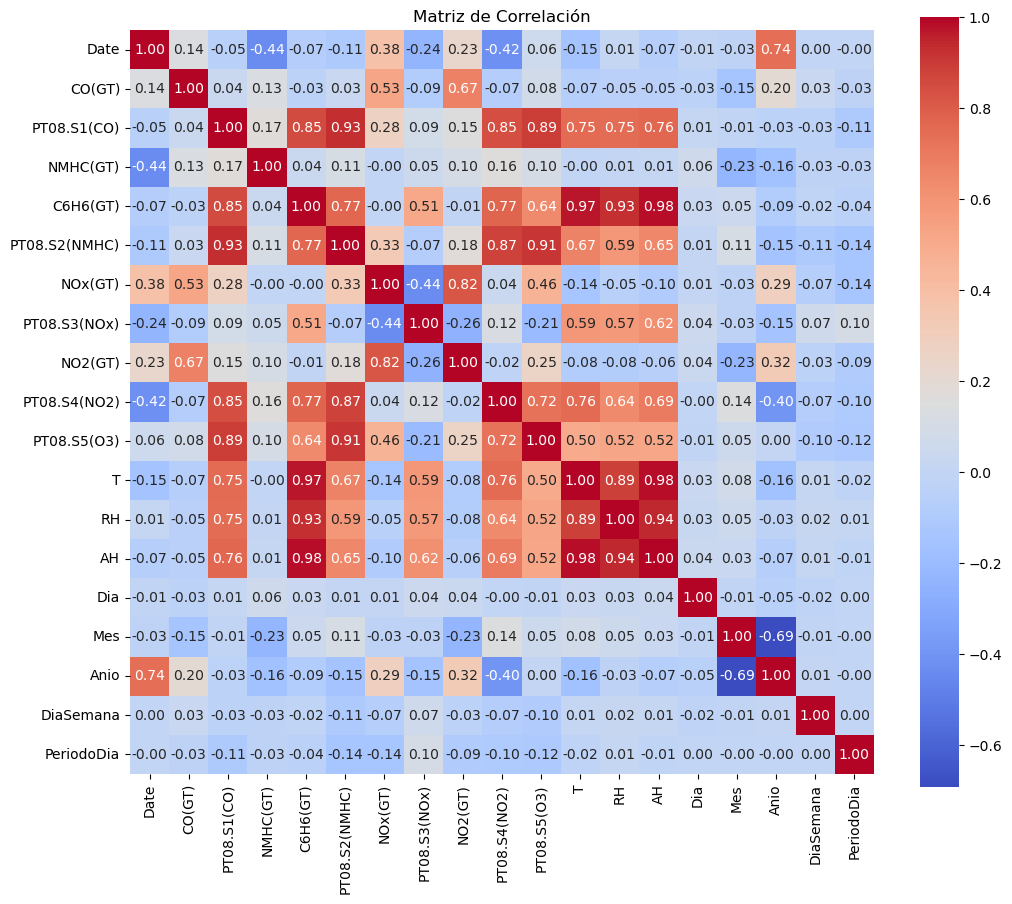

In [45]:
# Matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(df_cleaned.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación")
plt.show()

definir features y target 

predictors:
T: Temperatura ambiental medida en °C.
RH: Humedad relativa en el ambiente, expresada como un porcentaje.
AH: Humedad absoluta, una medida de la cantidad de vapor de agua en el aire.
PT08.S5(O3): Señal del sensor para ozono (O3), utilizado para medir la concentración de este gas.
PT08.S1(CO): Señal del sensor para monóxido de carbono (CO), utilizada para estimar su concentración.
PT08.S2(NMHC): Señal del sensor para compuestos orgánicos no metánicos (NMHC), representando su nivel en el aire.

targets:
CO(GT): Monóxido de carbono.
NMHC(GT): Compuestos orgánicos no metánicos.
C6H6(GT): Benceno.
NOx(GT): Óxidos de nitrógeno (una combinación de NO y NO2).
NO2(GT): Dióxido de nitrógeno.

In [46]:
# Definir predictores y objetivos
predictors = ['T', 'RH', 'AH']

targets = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)']


X = df_cleaned[predictors]
y = df_cleaned[targets]


MinMaxScaler: Es un método de escalado que transforma los valores de las características al rango [0, 1] (o a otro rango definido), manteniendo las relaciones proporcionales de los datos

In [47]:
# normalización
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Separar datos en entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

definir los modelos y sus hiperparametros 

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Definir modelos y sus hiperparámetros
param_grids = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'Support Vector Regressor': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'epsilon': [0.01, 0.1, 1]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        }
    },
    'Neural Network': {
        'model': MLPRegressor(max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd'],
            'learning_rate': ['constant', 'adaptive']
        }
    }
}

results = {}


Entrenar y evaluar cada modelo por variable objetivo

In [49]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenar y evaluar cada modelo por variable objetivo
for target in targets:
    print(f"\nOptimización de hiperparámetros para el objetivo: {target}")
    y_train_target = y_train[target]
    y_test_target = y_test[target]

    results[target] = {}
    
    for name, config in param_grids.items():
        model = config['model']
        params = config['params']
        
        # Configurar GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train_target)
        
        # Mejor modelo y evaluación
        best_model = grid_search.best_estimator_
        
        # Predicciones en entrenamiento y prueba
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        # Calcular métricas
        mse_train = mean_squared_error(y_train_target, y_train_pred)
        mse_test = mean_squared_error(y_test_target, y_test_pred)
        r2_train = r2_score(y_train_target, y_train_pred)
        r2_test = r2_score(y_test_target, y_test_pred)
        
        # Guardar resultados
        results[target][name] = {
            'Best Params': grid_search.best_params_,
            'MSE Train': mse_train,
            'MSE Test': mse_test,
            'R2 Train': r2_train,
            'R2': r2_test  # R2 de prueba
        }
        print(f"{name} mejor MSE: {mse_test:.4f}, R2: {r2_test:.4f}, Hiperparámetros: {grid_search.best_params_}")

# Crear un DataFrame con los resultados finales
rows = []
for target, metrics in results.items():
    for name, scores in metrics.items():
        rows.append({
            'Target': target,
            'Model': name,
            'MSE Train': scores['MSE Train'],
            'MSE Test': scores['MSE Test'],
            'R2 Train': scores['R2 Train'],
            'R2': scores['R2'],
            'Overfitting': scores['R2 Train'] - scores['R2'],  # Calcular sobreajuste
            'Best Params': scores['Best Params']
        })

results_df = pd.DataFrame(rows)

# Mostrar la tabla de resultados
print("Resultados Finales:")
print(results_df)

# Visualizar el sobreajuste con un gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='Overfitting', hue='Model', palette='coolwarm')
plt.title("Nivel de Sobreajuste por Modelo")
plt.ylabel("Diferencia (Training R2 - Test R2)")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualizar los R2 de prueba
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='R2', hue='Model', palette='viridis')
plt.title("Comparación de Modelos por R2")
plt.ylabel("R2")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualizar los MSE de prueba
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='MSE Test', hue='Model', palette='coolwarm')
plt.title("Comparación de Modelos por MSE")
plt.ylabel("MSE (Prueba)")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Optimización de hiperparámetros para el objetivo: PT08.S1(CO)
Linear Regression mejor MSE: 44340.1899, R2: 0.5915, Hiperparámetros: {}
Decision Tree mejor MSE: 46417.1428, R2: 0.5723, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 10}
Random Forest mejor MSE: 41287.0859, R2: 0.6196, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Gradient Boosting mejor MSE: 41650.8796, R2: 0.6162, Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Support Vector Regressor mejor MSE: 45384.2645, R2: 0.5818, Hiperparámetros: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
XGBoost mejor MSE: 41245.9935, R2: 0.6200, Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/SAA/lib/pyth

KeyboardInterrupt: 

ver resultados 

mirar sobre ajuste 

el pkl de imanoles

In [31]:
import joblib
joblib.dump(model, 'modelo_xgb_optimizado.pkl')

['modelo_xgb_optimizado.pkl']

In [32]:
import joblib

# Cargar el modelo en Python 3
model = joblib.load('modelo_xgb_optimizado.pkl')

# Guardarlo nuevamente en un formato compatible con Python 2 (protocolo 2)
joblib.dump(model, 'modelo_xgb_optimizado_v2.pkl', protocol=2)

['modelo_xgb_optimizado_v2.pkl']